# Imports and Setup

In [66]:
!pip install yfinance ta pandas --quiet

In [110]:
import yfinance as yf
import pandas as pd
import ta
import matplotlib.pyplot as plt
#i am using yfinance as my free stock stats provider api to get 6 month daily data.

#1. Fetching Stock Data

In [68]:
def fetch_and_process(stock):
   df = yf.download(stock, period="6mo", interval="1d")
   df.dropna(inplace=True)
#as you can see here i have used 6 month period with one day interval for each stock
   if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(filter(None, col)) for col in df.columns.values]
    # this was required to flatten multiindex columns for easier handling.
   return df

In [71]:
stocks=["RELIANCE.NS","TCS.NS","INFY.NS","LT.NS"]

In [72]:
stock_data={}

#2. Calculating Technical Indicators

In [134]:
def add_indicators(df):
    close_col = [col for col in df.columns if col.startswith('Close')][0]

    rsi_values = ta.momentum.RSIIndicator(close=df[close_col], window=14).rsi()
    df['RSI'] = rsi_values.values.flatten()
    df['20DMA'] = df[close_col].rolling(window=20).mean()
    df['50DMA'] = df[close_col].rolling(window=50).mean()

    return df
  #here i have used 3 indicators-rsi,20dma and 50dma as asked.
  # rsi(14 day)-to detect oversold conditions
  # 20dma and 50dma - to detect momentum trend

#3. Strategy Logic & Signal Generation

In [140]:
def generate_signals(df, rsi_threshold=50):
    df = df.copy()
    df['Signal'] = 0

    dma_cross = (df['20DMA'] > df['50DMA']) & (df['20DMA'].shift(1) <= df['50DMA'].shift(1))

    df.loc[dma_cross & (df['RSI'] < rsi_threshold), 'Signal'] = 1

    return df
#signals are generated considering they qualify the criteria
#where rsi<50 and 20 dma crosses above 50dma which means signal=buy(1)

In [141]:
for stock in stocks:
    df = fetch_and_process(stock)
    df = add_indicators(df)

    df = generate_signals(df, rsi_threshold=50)

    stock_data[stock] = df

    print(f"\nSignals generated for {stock}")
    print(df[df['Signal'] == 1][['RSI', '20DMA', '50DMA', 'Signal']])


/tmp/ipython-input-68-756596499.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, period="6mo", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-68-756596499.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, period="6mo", interval="1d")



Signals generated for RELIANCE.NS
Empty DataFrame
Columns: [RSI, 20DMA, 50DMA, Signal]
Index: []


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-68-756596499.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, period="6mo", interval="1d")



Signals generated for TCS.NS
Empty DataFrame
Columns: [RSI, 20DMA, 50DMA, Signal]
Index: []


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-68-756596499.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, period="6mo", interval="1d")



Signals generated for INFY.NS
Empty DataFrame
Columns: [RSI, 20DMA, 50DMA, Signal]
Index: []


[*********************100%***********************]  1 of 1 completed


Signals generated for LT.NS
                  RSI        20DMA        50DMA  Signal
Date                                                   
2025-04-04  41.894088  3300.186377  3295.544644       1


--> Only LT.NS of the 4 stocks I chose, triggered actual signals- which is expected based on recent price behaviour.

In [142]:
print(stock_data["RELIANCE.NS"].tail())

            Close_RELIANCE.NS  High_RELIANCE.NS  Low_RELIANCE.NS  \
Date                                                               
2025-06-23        1456.800049       1463.800049      1442.000000   
2025-06-24        1450.800049       1475.000000      1443.099976   
2025-06-25        1467.300049       1472.400024      1460.500000   
2025-06-26        1495.300049       1498.800049      1465.099976   
2025-06-27        1515.400024       1522.000000      1496.900024   

            Open_RELIANCE.NS  Volume_RELIANCE.NS        RSI        20DMA  \
Date                                                                       
2025-06-23       1453.000000             5989078  60.289167  1433.170007   
2025-06-24       1465.000000            16402744  57.988331  1434.605011   
2025-06-25       1464.000000             7525851  62.254419  1437.325012   
2025-06-26       1469.099976            14657893  68.162628  1441.200012   
2025-06-27       1499.400024            11115082  71.599321  1445.9

In [75]:
print(stock_data["RELIANCE.NS"][['RSI', '20DMA', '50DMA']].describe())


              RSI        20DMA        50DMA
count  112.000000   106.000000    76.000000
mean    55.931760  1303.455541  1289.682419
std     11.049446    81.745097    57.176029
min     27.097496  1215.162506  1236.441995
25%     49.292795  1244.521873  1240.915248
50%     57.403855  1256.849991  1261.913998
75%     62.118597  1405.077501  1338.298245
max     79.333233  1446.075012  1414.938008


In [76]:
print(stock_data["RELIANCE.NS"].columns)


Index(['Close_RELIANCE.NS', 'High_RELIANCE.NS', 'Low_RELIANCE.NS',
       'Open_RELIANCE.NS', 'Volume_RELIANCE.NS', 'RSI', '20DMA', '50DMA',
       'Signal'],
      dtype='object')


In [77]:
buy_days = stock_data["RELIANCE.NS"][stock_data["RELIANCE.NS"]['Signal'] == 1]
print(buy_days[['RSI', '20DMA', '50DMA', 'Signal']])


Empty DataFrame
Columns: [RSI, 20DMA, 50DMA, Signal]
Index: []


In [78]:
# Pick the stock
df = stock_data["LT.NS"]

# Redefine dma_cross in this scope
dma_cross = (df['20DMA'] > df['50DMA']) & (df['20DMA'].shift(1) <= df['50DMA'].shift(1))

# Now it works
df.loc[dma_cross & (df['RSI'] < 50), 'Signal'] = 1

# Check if signals were added
print(df[df['Signal'] == 1][['RSI', '20DMA', '50DMA', 'Signal']])


                  RSI        20DMA        50DMA  Signal
Date                                                   
2025-04-04  41.894088  3300.186377  3295.544644       1


In [146]:
# Example flattening (run once after fetching and adding indicators)
import pandas as pd

for stock, df in stock_data.items():
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(filter(None, col)) for col in df.columns.values]
    stock_data[stock] = df


#4. ML Automation
--> Here, I have tried to built a basic price movement predictor.

--> Target is whether next day's price > today's price



In [147]:
close_col = f'Close_{stock}'
volume_col = f'Volume_{stock}'

def prepare_features(df, stock=None):
    df = df.copy()
    if stock is None:
      raise ValueError("Provide stock ticker name")

    close_col = f'Close_{stock}'
    volume_col = f'Volume_{stock}'

    df['Close_Next'] = df[close_col].shift(-1)
    df['Target'] = (df['Close_Next'] > df[close_col]).astype(int)

    macd = ta.trend.MACD(close=df[close_col], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()

    df = df.dropna()

    feature_cols = ['RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', volume_col]

    X = df[feature_cols]
    y = df['Target']

    return X, y

# features used in model are rsi, macd, macd signal, macd diff, volume


In [148]:
df.columns

Index(['Close_LT.NS', 'High_LT.NS', 'Low_LT.NS', 'Open_LT.NS', 'Volume_LT.NS',
       'RSI', '20DMA', '50DMA', 'Signal'],
      dtype='object')

In [149]:
stock = 'RELIANCE.NS'
df = stock_data[stock]

df.columns = ['_'.join(filter(None, col)) if isinstance(col, tuple) else col for col in df.columns]

X, y = prepare_features(df,stock)

print("Features shape:", X.shape)
print("Label distribution:\n", y.value_counts())
X.head()


Features shape: (75, 5)
Label distribution:
 Target
1    42
0    33
Name: count, dtype: int64


,RSI,MACD,MACD_Signal,MACD_Diff,Volume_RELIANCE.NS
Date,,,,,
2025-03-06,47.035101,-16.441125,-13.081940,-3.359185,14468014
2025-03-07,57.743408,-11.397296,-12.745011,1.347715,16474965
2025-03-10,54.385423,-8.225098,-11.841029,3.615931,11931051
2025-03-11,56.511696,-4.936051,-10.460033,5.523982,10089838
2025-03-12,58.778615,-1.525133,-8.673053,7.147920,11977555


In [150]:
print(X.shape)
print(y.value_counts())


(75, 5)
Target
1    42
0    33
Name: count, dtype: int64


In [151]:
print(df.columns)


Index(['Close_RELIANCE.NS', 'High_RELIANCE.NS', 'Low_RELIANCE.NS',
       'Open_RELIANCE.NS', 'Volume_RELIANCE.NS', 'RSI', '20DMA', '50DMA',
       'Signal'],
      dtype='object')


In [152]:
df = df[df.index < pd.Timestamp.now().normalize()]
#i did this to normalise the statisitics of stocks to the last closing value if the day is not over yet.

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Test Accuracy: 46.67%


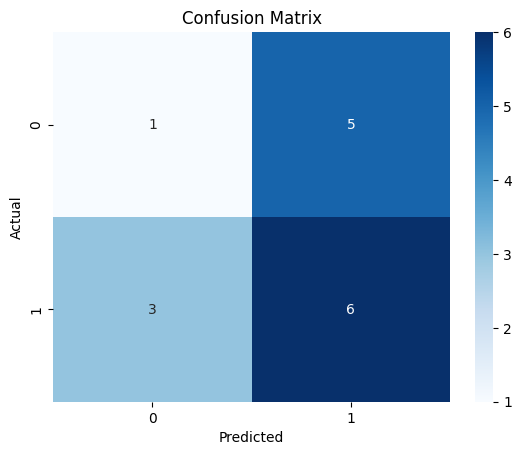

              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.55      0.67      0.60         9

    accuracy                           0.47        15
   macro avg       0.40      0.42      0.40        15
weighted avg       0.43      0.47      0.44        15



In [154]:
def train_and_evaluate(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.2%}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_test, y_pred))

    return model

model = train_and_evaluate(X, y)
# Here, model used is Logistic Regression.
# I also tried using decision tree classifier which brought me accuracy upto 60%
# but to due to less data and daily changing prices, accuracy dropped.
# a better model could be random forest which may increase accuracy to an extent.


#5. Google Sheets Logging
--> This part was quite tricky and new to me.


In [155]:
!pip install --quiet --upgrade gspread oauth2client


In [156]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials


In [157]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('algotradingproject-464023-40bafdaed2c0.json', scope)
client = gspread.authorize(creds)
sheet = client.open("Algo-Trading")
worksheet = sheet.worksheet("Trade Log")

#i used google sheet api to integrate this notebook to the data sheet.
# for this, gspread librrary was required along with the json key, which i acquired from my google cloud credentials.


In [158]:
records = worksheet.get_all_records()
print(records)

[{'Date\t': '2025-06-27', 'Stock': 'RELIANCE.NS', ' Signal': 'Buy', 'Price': 2500, ' RSI': 28, '20DMA': 2490, '50DMA': 2480}, {'Date\t': '2025-04-04', 'Stock': 'LT.NS', ' Signal': 'Buy', 'Price': 3230.03, ' RSI': 41.89, '20DMA': 3300.19, '50DMA': 3295.54}]


In [159]:
def log_trade_to_sheet(worksheet, trade_data):

    row = [trade_data['Date'], trade_data['Stock'], trade_data['Signal'], trade_data['Price'],
           trade_data['RSI'], trade_data['20DMA'], trade_data['50DMA']]
    worksheet.append_row(row)


In [165]:
import datetime

trade_example = {
    'Date': datetime.datetime.now().strftime("%Y-%m-%d"),
    'Stock': 'RELIANCE.NS',
    'Signal': 'Buy',
    'Price': 2500,
    'RSI': 28,
    '20DMA': 2490,
    '50DMA': 2480
}

log_trade_to_sheet(worksheet, trade_example)
print("Logged trade to sheet!")


Logged trade to sheet!


In [164]:
def log_signals_from_df(worksheet, df, stock_name):
    price_col = [col for col in df.columns if col.startswith('Close')][0]
    for date, row in df.iterrows():
        if row['Signal'] == 1:
            trade_data = {
                'Date': date.strftime("%Y-%m-%d"),
                'Stock': stock_name,
                'Signal': 'Buy',
                'Price': round(row[price_col], 2),
                'RSI': round(row['RSI'], 2),
                '20DMA': round(row['20DMA'], 2),
                '50DMA': round(row['50DMA'], 2),
            }
            log_trade_to_sheet(worksheet, trade_data)
            print(f"Logged trade for {stock_name} on {trade_data['Date']}")
#logged each buy signal to the trade log tab
# all the headers data, stock, signal, price, rsi, 20dma, 50dma are logged.

In [162]:
print(f"Columns in {stock}: {df.columns.tolist()}")


Columns in RELIANCE.NS: ['Close_RELIANCE.NS', 'High_RELIANCE.NS', 'Low_RELIANCE.NS', 'Open_RELIANCE.NS', 'Volume_RELIANCE.NS', 'RSI', '20DMA', '50DMA', 'Signal']


In [163]:
for stock in stock_data:
    df = stock_data[stock]
    log_signals_from_df(worksheet, df, stock)


Logged trade for LT.NS on 2025-04-04


# 6. P&L Summary and Win Ratio
--> in this final part, i was required to automate performance tracking, by

*   returning trades from sheet
*   looking up next day close price for that stock
*   calcuating profit or loss per trade
*   then sum it up in

    *   PnL Summary tab
    *   and the Summary tab (total trades, wins and win ratio)
*   An additional thing I did was to make it all in one final pipeline to run both pnl and summary tab at once.







In [126]:
gimport datetime

def generate_pnl_summary(sheet, stock_data):

    trade_log = sheet.worksheet("Trade Log")
    trade_data = trade_log.get_all_records()

    pnl_rows = []

    for raw_trade in trade_data:
        trade = {k.strip(): v for k, v in raw_trade.items()}

        trade_date = datetime.datetime.strptime(trade['Date'], "%Y-%m-%d").date()
        stock = trade['Stock']
        buy_price = float(trade['Price'])

        df = stock_data.get(stock)
        if df is None:
            continue

        after_dates = df.index[df.index > pd.to_datetime(trade_date)]
        if len(after_dates) < 3:
            continue
        sell_date = after_dates[2]

        close_col = [col for col in df.columns if col.startswith('Close')][0]
        sell_price = float(df.at[sell_date, close_col])

        pnl = sell_price - buy_price
        return_pct = (pnl / buy_price) * 100

        pnl_rows.append([
            trade_date.strftime("%Y-%m-%d"),
            stock,
            round(buy_price, 2),
            round(sell_price, 2),
            round(pnl, 2),
            round(return_pct, 2)
        ])

    try:
        existing = sheet.worksheet("P&L Summary")
        sheet.del_worksheet(existing)
    except gspread.exceptions.WorksheetNotFound:
        pass

    pnl_ws = sheet.add_worksheet(title="P&L Summary", rows=str(len(pnl_rows)+5), cols="6")
    headers = ["Date", "Stock", "Buy Price", "Sell Price", "PnL", "% Return"]
    pnl_ws.append_row(headers)

    for row in pnl_rows:
        pnl_ws.append_row(row)

    print(f"Wrote {len(pnl_rows)} P&L rows to 'P&L Summary'")


In [127]:
generate_pnl_summary(sheet, stock_data)


Wrote 3 P&L rows to 'P&L Summary'


In [129]:
def generate_win_ratio(sheet):
    try:
        pnl_ws = sheet.worksheet("P&L Summary")
        data = pnl_ws.get_all_records()
    except:
        print("'P&L Summary' sheet not found.")
        return

    if not data:
        print("No trade data to summarize.")
        return

    wins = sum(1 for row in data if float(row.get("PnL", 0)) > 0)
    losses = len(data) - wins
    win_ratio = (wins / len(data)) * 100

    try:
        summary_ws = sheet.worksheet("Summary P&L")
        sheet.del_worksheet(summary_ws)
    except:
        pass

    summary_ws = sheet.add_worksheet(title="Summary P&L", rows="10", cols="2")

    summary_ws.append_row(["Metric", "Value"])
    summary_ws.append_row(["Total Trades", len(data)])
    summary_ws.append_row(["Winning Trades", wins])
    summary_ws.append_row(["Losing Trades", losses])
    summary_ws.append_row(["Win Ratio (%)", round(win_ratio, 2)])

    print(f"Win Ratio tab created — {wins} wins out of {len(data)} trades → {round(win_ratio, 2)}% success rate.")


In [130]:
generate_win_ratio(sheet)

Win Ratio tab created — 0 wins out of 3 trades → 0.0% success rate.


In [131]:
def run_full_pipeline(sheet, stock_data):
    generate_pnl_summary(sheet, stock_data)
    generate_win_ratio(sheet)
#only one function to run both summary and win ratio

In [132]:
run_full_pipeline(sheet, stock_data)

Wrote 3 P&L rows to 'P&L Summary'
Win Ratio tab created — 0 wins out of 3 trades → 0.0% success rate.
